In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [145]:
#加载数据
data = pd.read_csv('movielens_sample.txt')
data.head()
data.info()
target = data.pop('rating')
data['ColumnA'] = data['genres'].str.split('|',expand = True).apply(
    lambda x:( ','.join(x.dropna().astype(str))).replace('\'',''),
    axis=1
)
data = data.drop('ColumnA', 1).join(data['ColumnA'].str.get_dummies(','))
for feature in data.columns:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature])
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
user_id       200 non-null int64
movie_id      200 non-null int64
rating        200 non-null int64
timestamp     200 non-null int64
title         200 non-null object
genres        200 non-null object
gender        200 non-null object
age           200 non-null int64
occupation    200 non-null int64
zip           200 non-null object
dtypes: int64(6), object(4)
memory usage: 15.8+ KB


Index(['user_id', 'movie_id', 'timestamp', 'title', 'genres', 'gender', 'age',
       'occupation', 'zip', 'Action', 'Adventure', 'Animation', 'Childrens',
       'Comedy', 'Crime', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

GBDT回归MSE: 1.7191358737221454
各个特征的重要程度， [1.40249052e-01 1.82361048e-01 1.23513465e-01 1.77129223e-01
 5.99036409e-02 4.91728763e-03 2.49321225e-02 6.81328135e-02
 1.27408839e-01 1.97886713e-03 9.20896561e-03 0.00000000e+00
 2.97011843e-03 1.40008416e-03 3.61509755e-03 2.60173875e-02
 8.96325833e-04 0.00000000e+00 7.47552708e-04 4.78258900e-05
 2.33198650e-03 7.80684160e-03 1.78824813e-03 3.06609649e-02
 9.72425418e-04 1.00981579e-03]


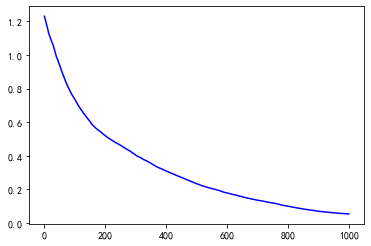

In [146]:
#用GBDT看下feature的重要性
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test =  train_test_split(data, target, test_size=0.2)
clf = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=4, loss ='ls')
clf.fit(X_train, y_train)
print('GBDT回归MSE:', mean_squared_error(y_test, clf.predict(X_test)))
print('各个特征的重要程度，',clf.feature_importances_)
plt.plot(np.arange(1000),clf.train_score_, 'b-')
plt.show()

In [147]:
feature_score = dict(zip(data.columns, clf.feature_importances_))
feature_score = sorted(feature_score.items(), key=lambda x :x[1], reverse=True)
feature_score

[('movie_id', 0.18236104821768598),
 ('title', 0.177129223471951),
 ('user_id', 0.14024905246736694),
 ('zip', 0.1274088394677003),
 ('timestamp', 0.12351346474604943),
 ('occupation', 0.06813281349135877),
 ('genres', 0.05990364089298365),
 ('Thriller', 0.030660964903247906),
 ('Drama', 0.02601738745929859),
 ('age', 0.024932122507953812),
 ('Adventure', 0.00920896561041426),
 ('Romance', 0.007806841603287006),
 ('gender', 0.0049172876313263005),
 ('Crime', 0.0036150975491406577),
 ('Childrens', 0.0029701184295328723),
 ('Mystery', 0.0023319864962882573),
 ('Action', 0.0019788671272241666),
 ('Sci-Fi', 0.0017882481265064898),
 ('Comedy', 0.0014000841589009204),
 ('Western', 0.0010098157918269279),
 ('War', 0.000972425418448111),
 ('Fantasy', 0.0008963258334366681),
 ('Horror', 0.0007475527081187451),
 ('Musical', 4.782588995232738e-05),
 ('Animation', 0.0),
 ('Film-Noir', 0.0)]

# 疑问？
# 1.不知道这种方式获取特征重要程度是否有效
# 2.title的重要程度也很高，是否和movie_id重复
# 3.这边先取大于0.01的特征进行训练，但实践发现选所有的特征，效果更好些，所以还是改为0
   

In [148]:
new_feature = [ i[0] for i in feature_score if i[1] >0]
data = data[new_feature]
data.columns

Index(['movie_id', 'title', 'user_id', 'zip', 'timestamp', 'occupation',
       'genres', 'Thriller', 'Drama', 'age', 'Adventure', 'Romance', 'gender',
       'Crime', 'Childrens', 'Mystery', 'Action', 'Sci-Fi', 'Comedy',
       'Western', 'War', 'Fantasy', 'Horror', 'Musical'],
      dtype='object')

# Wild & Deep
# 疑问？发现epochs在35之后增大，是不是说直接取35就行？

In [160]:
from deepctr.models import WDL
from deepctr.feature_column import SparseFeat, get_feature_names
fixlen_feature_columns = [SparseFeat(feature, data[feature].nunique()) for feature in data.columns]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

all_data = data.copy()
all_data['rating'] = target.values
train, test = train_test_split(all_data, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

model = WDL(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile('adam', 'mse', metrics=['mse'],)
history = model.fit(train_model_input, train['rating'].values, batch_size=256, epochs=100, verbose=True, validation_split=0.2, )
pred_ans = model.predict(test_model_input, batch_size=256)
mse = round(mean_squared_error(test['rating'].values, pred_ans), 4)
rmse = mse ** 0.5
print('test RMSE', rmse)

Train on 128 samples, validate on 32 samples
Epoch 1/100


d:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
d:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


128/128 [==============================] - 10s 75ms/sample - loss: 14.1691 - mse: 14.1691 - val_loss: 14.0023 - val_mse: 14.0023
Epoch 2/100
128/128 [==============================] - 0s 1ms/sample - loss: 13.9166 - mse: 13.9166 - val_loss: 13.7716 - val_mse: 13.7716
Epoch 3/100
128/128 [==============================] - 0s 2ms/sample - loss: 13.6444 - mse: 13.6444 - val_loss: 13.5286 - val_mse: 13.5286
Epoch 4/100
128/128 [==============================] - 0s 997us/sample - loss: 13.3596 - mse: 13.3596 - val_loss: 13.2753 - val_mse: 13.2753
Epoch 5/100
128/128 [==============================] - 0s 1ms/sample - loss: 13.0639 - mse: 13.0639 - val_loss: 13.0111 - val_mse: 13.0111
Epoch 6/100
128/128 [==============================] - 0s 1ms/sample - loss: 12.7561 - mse: 12.7561 - val_loss: 12.7346 - val_mse: 12.7346
Epoch 7/100
128/128 [==============================] - 0s 1ms/sample - loss: 12.4347 - mse: 12.4347 - val_loss: 12.4446 - val_mse: 12.4446
Epoch 8/100
128/128 [==============

Epoch 61/100
128/128 [==============================] - 0s 1ms/sample - loss: 0.1446 - mse: 0.1445 - val_loss: 1.7090 - val_mse: 1.7089
Epoch 62/100
128/128 [==============================] - 0s 1ms/sample - loss: 0.1259 - mse: 0.1259 - val_loss: 1.6878 - val_mse: 1.6878
Epoch 63/100
128/128 [==============================] - 0s 1ms/sample - loss: 0.1122 - mse: 0.1121 - val_loss: 1.6782 - val_mse: 1.6781
Epoch 64/100
128/128 [==============================] - 0s 1ms/sample - loss: 0.1010 - mse: 0.1010 - val_loss: 1.6797 - val_mse: 1.6797
Epoch 65/100
128/128 [==============================] - 0s 1ms/sample - loss: 0.0901 - mse: 0.0900 - val_loss: 1.6926 - val_mse: 1.6926
Epoch 66/100
128/128 [==============================] - 0s 1ms/sample - loss: 0.0780 - mse: 0.0780 - val_loss: 1.7166 - val_mse: 1.7165
Epoch 67/100
128/128 [==============================] - 0s 1ms/sample - loss: 0.0646 - mse: 0.0646 - val_loss: 1.7511 - val_mse: 1.7510
Epoch 68/100
128/128 [==========================

In [159]:
pred_ans

array([[2.6183941],
       [2.6633735],
       [3.5405693],
       [3.2587543],
       [2.5279217],
       [2.7047548],
       [3.1182153],
       [2.653059 ],
       [2.7105412],
       [2.4662442],
       [2.6249192],
       [2.545899 ],
       [2.4305682],
       [3.1654277],
       [2.558536 ],
       [2.512289 ],
       [2.6722014],
       [2.4074092],
       [2.487164 ],
       [2.6013496],
       [2.6618092],
       [2.7151165],
       [2.6487825],
       [1.8921854],
       [2.5550926],
       [3.5614574],
       [2.5128865],
       [2.9435408],
       [2.7233155],
       [2.7166457],
       [2.7701504],
       [2.7552369],
       [2.7151165],
       [2.450087 ],
       [2.685621 ],
       [2.6323783],
       [2.7027802],
       [2.7546558],
       [2.3742847],
       [2.8740137]], dtype=float32)

In [152]:
test['rating'].values

array([3, 4, 5, 3, 3, 4, 5, 1, 3, 2, 2, 3, 5, 2, 3, 3, 5, 3, 5, 5, 4, 3,
       2, 2, 3, 5, 5, 4, 3, 4, 4, 2, 3, 5, 3, 5, 4, 2, 4, 5], dtype=int64)